In [ ]:
!pip3 install rdkit


In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdDepictor
from rdkit.Chem.rdDepictor import Compute2DCoords
import glob
import pandas as pd

In [ ]:
# Merge csv files into one dataframe using glob library

csv_files = glob.glob('/content/drive/MyDrive/Colab Notebooks/**/*.csv', recursive=True)
data = pd.DataFrame()
data = pd.concat([pd.read_csv(files) for files in csv_files], ignore_index = True)
data


,zinc_id,smiles
0,ZINC000000001084,Cn1c(=O)c2c(ncn2C)n(C)c1=O
1,ZINC000000033882,NCCc1ccc(O)c(O)c1
2,ZINC000000001411,C=CCc1ccc(O)c(OC)c1
3,ZINC000001482164,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O
4,ZINC000001532517,CC(=O)C(=O)O


In [ ]:
# Add a new column to the dataframe at the location 0
molecules = ['Ice', 'Dopamine', 'Eugenol', 'Caffeine', 'Pyruvate']
data.insert(0, 'Molecules', molecules)
data

,Molecules,zinc_id,smiles
0,Ice,ZINC000000001084,Cn1c(=O)c2c(ncn2C)n(C)c1=O
1,Dopamine,ZINC000000033882,NCCc1ccc(O)c(O)c1
2,Eugenol,ZINC000000001411,C=CCc1ccc(O)c(OC)c1
3,Caffeine,ZINC000001482164,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O
4,Pyruvate,ZINC000001532517,CC(=O)C(=O)O


In [ ]:
# Calculate the Molecular Weight
data['MolWt'] = data['smiles'].apply(lambda smiles: Chem.Descriptors.MolWt(Chem.MolFromSmiles(smiles))
if Chem.MolFromSmiles(smiles) else None)

# Calculate the number of heavy atoms
data['HeavyAtoms_number'] = data['smiles'].apply(lambda smiles: Chem.Descriptors.HeavyAtomCount(Chem.MolFromSmiles(smiles))
if Chem.MolFromSmiles(smiles) else None)

# Calculate the number of rotatable bonds
data['Rotatable_bonds'] = data['smiles'].apply(lambda smiles: Chem.Descriptors.NumRotatableBonds(Chem.MolFromSmiles(smiles))
if Chem.MolFromSmiles(smiles) else None)

# Calculate logP
data['logP'] = data['smiles'].apply(lambda smiles: Chem.Descriptors.MolLogP(Chem.MolFromSmiles(smiles))
if Chem.MolFromSmiles(smiles) else None)

data


,Molecules,zinc_id,smiles,MolWt,HeavyAtoms_number,Rotatable_bonds,logP
0,Ice,ZINC000000001084,Cn1c(=O)c2c(ncn2C)n(C)c1=O,194.194,14,0,-1.0293
1,Dopamine,ZINC000000033882,NCCc1ccc(O)c(O)c1,153.181,11,2,0.5990
2,Eugenol,ZINC000000001411,C=CCc1ccc(O)c(OC)c1,164.204,12,3,2.1293
3,Caffeine,ZINC000001482164,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O,156.269,11,1,2.4395
4,Pyruvate,ZINC000001532517,CC(=O)C(=O)O,88.062,6,1,-0.3400


In [ ]:
# Apply the conditions:
'''
1. the molecular weight of molecules must be between 100-700 Da;
2. total number of atoms of each molecule must be less than or equal to 60;
3. number of rotatable bonds must be less than or equal to 15;
4. octonal-water coefficient (logP) must be less than or equal to 5.
'''

data = data.loc[(data['MolWt']<700) & (data['MolWt'] > 100) &
 (data['HeavyAtoms_number'] <= 60) & (data['Rotatable_bonds'] <= 15) &
  (data['logP'] <= 5)]

data

,Molecules,zinc_id,smiles,MolWt,HeavyAtoms_number,Rotatable_bonds,logP
0,Ice,ZINC000000001084,Cn1c(=O)c2c(ncn2C)n(C)c1=O,194.194,14,0,-1.0293
1,Dopamine,ZINC000000033882,NCCc1ccc(O)c(O)c1,153.181,11,2,0.5990
2,Eugenol,ZINC000000001411,C=CCc1ccc(O)c(OC)c1,164.204,12,3,2.1293
3,Caffeine,ZINC000001482164,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O,156.269,11,1,2.4395


In [ ]:
# Make a list with all the Morgan fingerprints of all molecules
fp_list = []
for smiles in data['smiles']:
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fp_list.append(fp)

# Make a new dataframe
similarity_matrix = pd.DataFrame(index=data['Molecules'],
                                 columns=data['Molecules'])

# Calculate Tanimoto Similarity through the nested loop
for i in range(len(fp_list)):
  mol1 = fp_list[i]
  for j in range(i + 1, len(fp_list)):  # starting from i+1 to the end
        mol2 = fp_list[j]
        if mol1 and mol2 != None:
            tanimoto_coeff = DataStructs.TanimotoSimilarity(mol1, mol2)
            # set value (tanimoto_coeff) for a cell witt index i/j and column j/i
            # Other alternative for iloc whould be .iat method
            similarity_matrix.iat [i, j] = tanimoto_coeff
            similarity_matrix.iat [j, i] = tanimoto_coeff

print(similarity_matrix)

Molecules       Ice  Dopamine   Eugenol  Caffeine
Molecules                                        
Ice             NaN  0.045455      0.06  0.022222
Dopamine   0.045455       NaN  0.324324   0.02439
Eugenol        0.06  0.324324       NaN  0.042553
Caffeine   0.022222   0.02439  0.042553       NaN


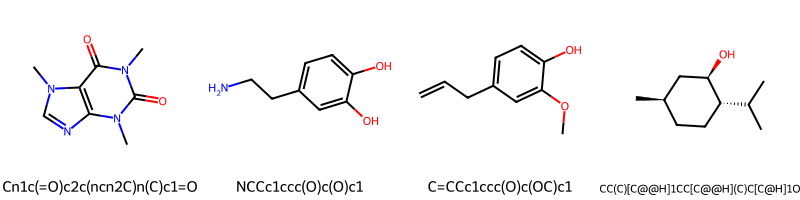

In [ ]:
from rdkit.Chem import Draw

# Draw the 2D structure of moleules
mol_list = []
for smiles in data['smiles']:
  mol = Chem.MolFromSmiles(smiles)
  mol_list.append(mol)

img = Draw.MolsToGridImage(mol_list, molsPerRow= 4, useSVG=True, legends = list(data['smiles']))
img
